In [6]:
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""

test_run = 1
test_run = bool(test_run)

model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1' # means llama-7b finetuned on tulu humanmix already.

save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

    
# dataset_list = [
#     'flan_v2', 
# ] 
# sort_by_list = [
# #     'random', 'prob', 'el2n',
# #     'kmeansl2_nc=300', 'kmeansl2_nc=1000', 'kmeansl2_nc=3000',
# #     'dppmap_k=Kcos', 'dppmap_k=Kcosp', 'dppmap_k=Kcos1np', 
#     'kmeanscd_nc=3000',
# ]


dataset_list = ['flan2022_1m']
# sort_by_list = [
#     'random', 'prob', 'el2n',
#     'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# ]
sort_by_list = [
    'kmeansl2_nc=6000',
]

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --lm_output_dir {lm_output_dir} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = False

Submiting job with:
{
    "job_name": "prune.flan2022_1m.kmeansl2_nc=6000",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset flan2022_1m --sort_by kmeansl2_nc=6000 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/
#cmds:  1


In [2]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [3]:
import os
import sys
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,)

In [5]:
test_run = True
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'

# sort_by = 'random'
sort_by = 'kmeansl2_nc=3000'
sort_by = 'kmeanscd_nc=3000'
# sort_by = 'prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'

# used for generating model output.
model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
save_dir = os.path.join(save_dir, dataset)
os.makedirs(save_dir, exist_ok=True)

In [17]:

save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
if test_run:
    d = {k: v[:10000] for k, v in d.items()}

# some entries are nan, impute with mean value.
text_embeddings = d['text_embeddings']
log_probs = np.nan_to_num(d['log_probs'], nan=np.nanmean(d['log_probs'])).squeeze()
el2ns = np.nan_to_num(d['el2ns'], nan=np.nanmean(d['el2ns'])).squeeze()

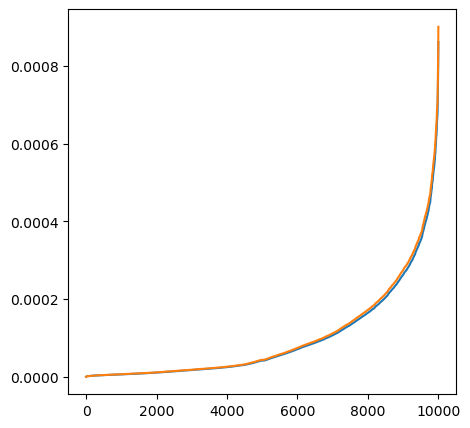

In [24]:
import scipy

scipy.special.softmax(log_probs)

array([7.7290912e-05, 2.4124084e-04, 7.0722999e-06, ..., 3.1388186e-05,
       6.3639868e-06, 2.4495961e-05], dtype=float32)

IndexError: index 6072 is out of bounds for axis 0 with size 3000

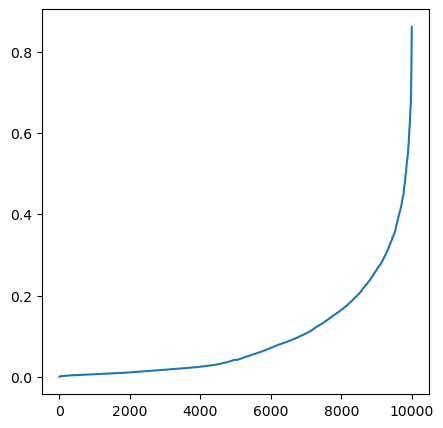

In [50]:


np.random.seed(0)
sampled_inds = np.random.choice(len(log_probs), size=3000, replace=False, p=scipy.special.softmax(log_probs))



import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(np.exp(log_probs)[sort_inds])

xs = [d[x] for x in sampled_inds][::100]
ax.scatter(xs, np.ones(len(xs)), alpha=.1)

# ax.scatter(sampled_inds, np.sort(np.exp(log_probs)[sampled_inds]))

# ax.plot(np.sort(scipy.special.softmax(log_probs)))


In [51]:
d = {i:x for i, x in enumerate(sort_inds)}


In [17]:
import time
t0 = time.time()

if sort_by.startswith('random'):
    random.seed(0)
    inds = list(range(log_probs.shape[0]))
    random.shuffle(inds)
elif sort_by == 'prob':
    S = log_probs
elif sort_by == 'el2n':
    S = el2ns
elif sort_by == 'sampprob':
    
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'(?<=\=)\d+', sort_by)
    n_clusters = int(match.group()) if match else None
    S = sort_kmeans_dist_to_cluster_centers(text_embeddings[:10000], n_clusters, dist_fn=dist_fn)
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None  
    inds = sort_dpp_map(text_embeddings, log_probs, kernel_type=kernel_type)

if any(sort_by.startswith(x) for x in ['dpp', 'random']):
    save_to_pickle(
        save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
        output={'inds': inds})
else:
    save_sorted_inds(save_dir, S, sort_by, reverse=False)
    save_sorted_inds(save_dir, S, sort_by, reverse=True)

t1 = time.time()
t = t1-t0
print(f'{t:2f}')

Running <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> to compute cosine distance to cluster centers.
Init 1/10 with method k-means++



KeyboardInterrupt



In [15]:
a = np.random.rand(10000,4096).astype(np.float32)
b = np.random.rand(10000,4096).astype(np.float32)
%timeit np.sum(a*b,axis=-1)

55.1 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
a = np.random.rand(10000,4096).astype(np.float64)
b = np.random.rand(10000,4096).astype(np.float64)
%timeit np.sum(a*b,axis=-1)

92.3 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
